In [0]:
from fastai.vision import *

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [7]:
path = Path('gdrive/My Drive/pothole_classification')

for file, folder in [('potholes.csv', 'pothole'), ('no_potholes.csv', 'not_pothole')]:
    dest = path/folder # path + '/' + folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(path/file, dest);

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

In [6]:
for folder in ['pothole','not_pothole']:
    verify_images(path/folder, delete=True, max_size=500)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


In [8]:
data.classes

['not_pothole', 'pothole']

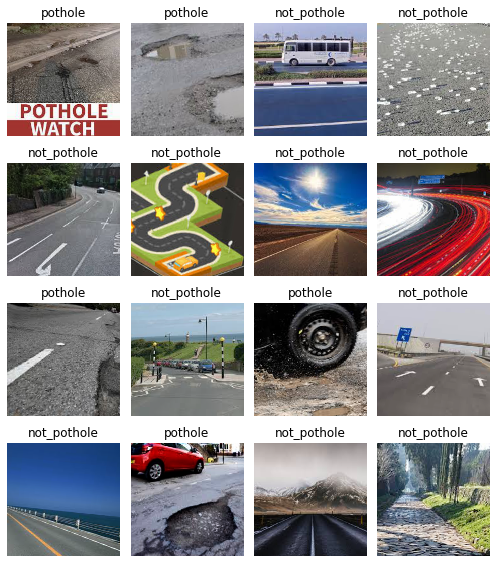

In [9]:
data.show_batch(rows=4, figsize=(7, 8))

In [0]:
data.save()

In [10]:
import os, os.path

print(len([name for name in os.listdir('pothole')]))
print(len([name for name in os.listdir('not_pothole')]))

480
635


In [0]:
from fastai.metrics import error_rate # 1 - accuracy
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
defaults.device = torch.device('cuda') # makes sure the gpu is used

In [12]:
learn.fit_one_cycle(4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


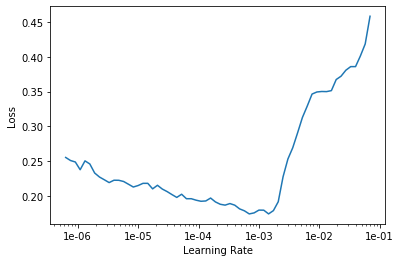

In [13]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(4, max_lr=slice(2e-5, 2e-4))


In [0]:
learn.save('pothole-stage-1')

In [8]:
df = pd.read_csv(path/'cleaned.csv', header='infer')
df['name'] = df['name'].apply(lambda x: x.replace('gdrive/My Drive/pothole_classification/',''))
print(df.head())

                   name    label
0  pothole/00000004.jpg  pothole
1  pothole/00000000.jpg  pothole
2  pothole/00000001.jpg  pothole
3  pothole/00000006.jpg  pothole
4  pothole/00000007.jpg  pothole


In [0]:
db = (ImageList.from_df(df, path)
                   .split_by_rand_pct(0.2)
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch(bs=8)).normalize(imagenet_stats)

In [0]:
db.save()

In [29]:
db

ImageDataBunch;

Train: LabelList (562 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pothole,pothole,pothole,pothole,pothole
Path: gdrive/My Drive/pothole_classification;

Valid: LabelList (140 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
not_pothole,pothole,not_pothole,not_pothole,not_pothole
Path: gdrive/My Drive/pothole_classification;

Test: None

In [11]:
# print(data.classes, data.c, len(data.train_ds), len(data.valid_ds))
print(db.classes, db.c, len(db.train_ds), len(db.valid_ds))

['not_pothole', 'pothole'] 2 562 140


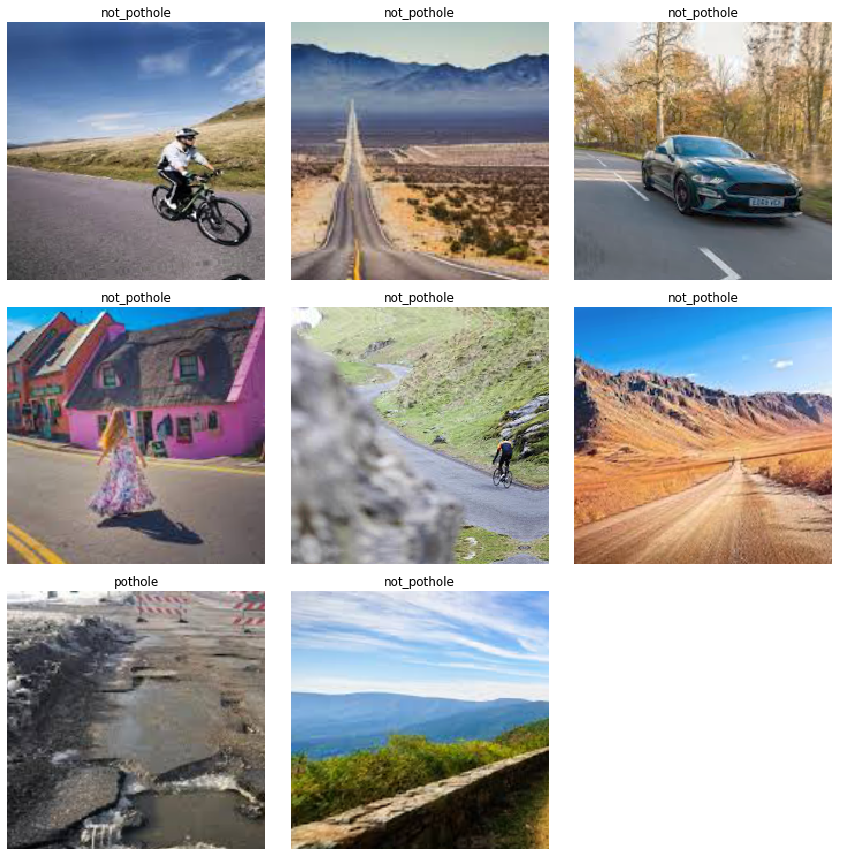

In [12]:
db.show_batch()

In [0]:
learn=cnn_learner(db, models.resnet34, metrics=error_rate)
learn.load("pothole-stage-1");

In [31]:
learn.load('pothole-stage-1') # loading the weights
learn.data = db # replacing the data

learn.freeze()
learn.fit_one_cycle(4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


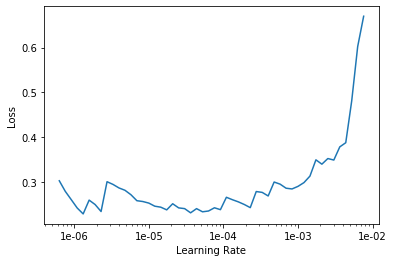

In [33]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(4, max_lr=slice(5e-6, 5e-4))
learn.save('pothole-stage-2')

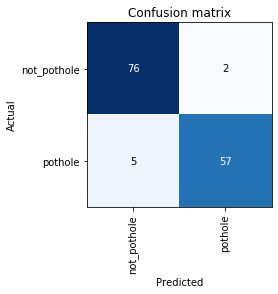

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

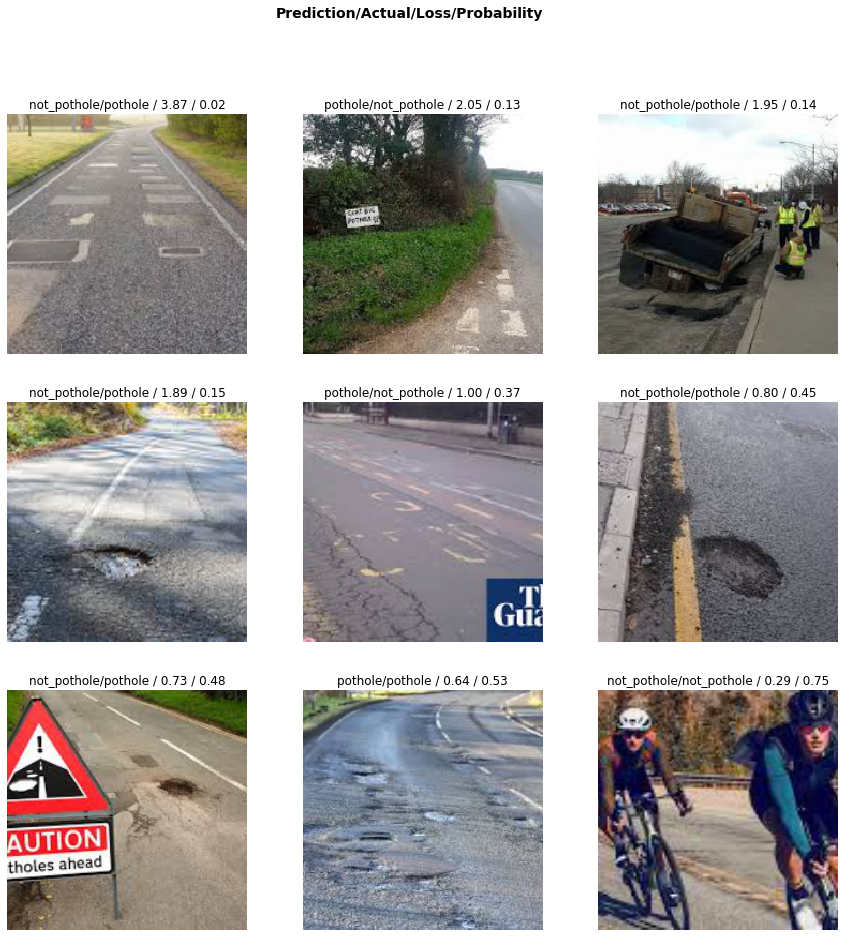

In [36]:
interp.plot_top_losses(9, figsize=(15,15))

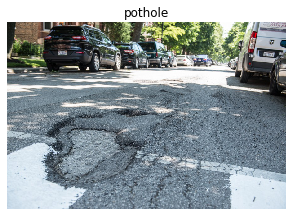

In [57]:
open_image(path/"ptest2.jpg").show(figsize=(5,5), title="pothole")

In [44]:
learn.predict(open_image(path/"ptest2.jpg"))

(Category pothole, tensor(1), tensor([0.0058, 0.9942]))

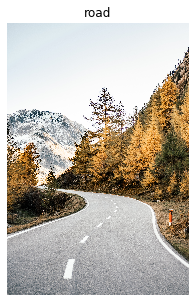

In [56]:
open_image(path/"roadtest.jpg").show(figsize=(5,5), title="road")

In [48]:
learn.predict(open_image(path/"roadtest.jpg"))

(Category not_pothole, tensor(0), tensor([9.9989e-01, 1.0535e-04]))

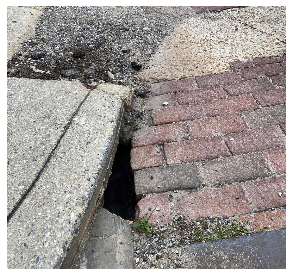

In [59]:
open_image(path/"p1.jpeg").show(figsize=(5,5))

In [60]:
learn.predict(open_image(path/"p1.jpeg"))

(Category pothole, tensor(1), tensor([0.0041, 0.9959]))

(Category pothole, tensor(1), tensor([0.0235, 0.9765]))

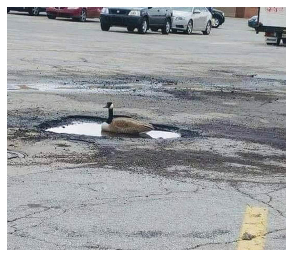

In [67]:
open_image(path/"p2.jpeg").show(figsize=(5,5))
learn.predict(open_image(path/"p2.jpeg"))

(Category not_pothole, tensor(0), tensor([9.9948e-01, 5.1777e-04]))

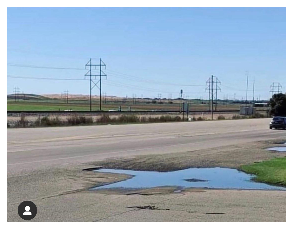

In [63]:
open_image(path/"p3.jpeg").show(figsize=(5,5))
learn.predict(open_image(path/"p3.jpeg"))

(Category pothole, tensor(1), tensor([0.2442, 0.7558]))

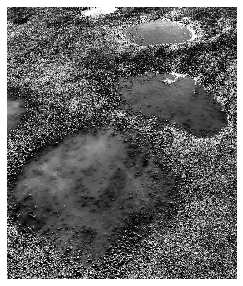

In [64]:
open_image(path/"p4.jpeg").show(figsize=(5,5))
learn.predict(open_image(path/"p4.jpeg"))

(Category not_pothole, tensor(0), tensor([0.9374, 0.0626]))

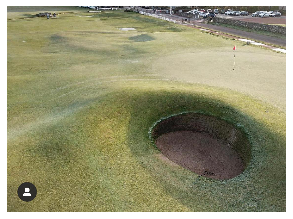

In [65]:
open_image(path/"p5.jpeg").show(figsize=(5,5))
learn.predict(open_image(path/"p5.jpeg"))

(Category not_pothole, tensor(0), tensor([9.9991e-01, 8.8739e-05]))

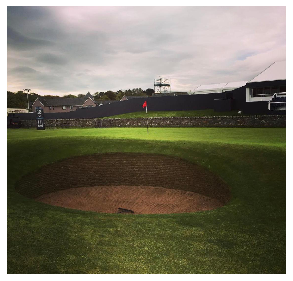

In [66]:
open_image(path/"p6.jpeg").show(figsize=(5,5))
learn.predict(open_image(path/"p6.jpeg"))

(Category not_pothole, tensor(0), tensor([1.0000e+00, 3.8685e-06]))

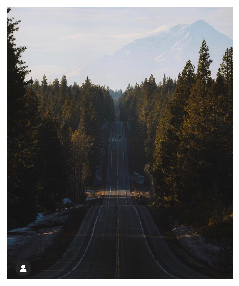

In [68]:
open_image(path/"r1.jpeg").show(figsize=(5,5))
learn.predict(open_image(path/"r1.jpeg"))

(Category not_pothole, tensor(0), tensor([0.7771, 0.2229]))

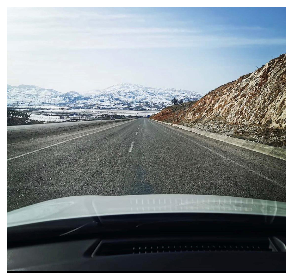

In [69]:
open_image(path/"r2.jpeg").show(figsize=(5,5))
learn.predict(open_image(path/"r2.jpeg"))

(Category not_pothole, tensor(0), tensor([0.9390, 0.0610]))

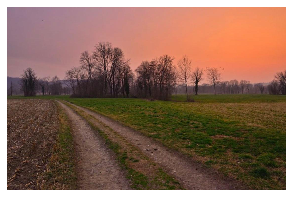

In [71]:
open_image(path/"r3.jpeg").show(figsize=(5,5))
learn.predict(open_image(path/"r3.jpeg"))

In [0]:
learn.export()